In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import random
from collections import Counter
from scipy import interpolate

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(0)

In [54]:
user_spec = pd.read_csv('./data/user_spec.csv', encoding = 'utf8')
loan_result = pd.read_csv('./data/loan_result.csv', encoding = 'utf8')
log_data = pd.read_csv('./data/log_data.csv', encoding = 'utf8')

In [74]:
data = pd.merge(loan_result, user_spec, on = 'application_id', how = 'left')

In [5]:
data['날짜'] = data.loanapply_insert_time.str.extract('([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9])')

In [6]:
data.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,날짜
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07


In [6]:
kospi = pd.read_csv('./data/코스피지수.csv', encoding = 'utf8', usecols = [0,1])
kospi.rename(columns={"종가":"kospi"}, inplace=True)
kospi = kospi.interpolate()
kospi

,날짜,kospi
0,2022-02-28,2699.180000
1,2022-03-01,2701.350000
2,2022-03-02,2703.520000
3,2022-03-03,2747.080000
4,2022-03-04,2713.430000
...,...,...
118,2022-06-26,2390.146667
119,2022-06-27,2401.920000
120,2022-06-28,2422.090000
121,2022-06-29,2377.990000


In [7]:
data = pd.merge(data, kospi, on = '날짜', how = 'left')

In [8]:
data = data.drop(columns='날짜')

In [10]:
data.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,kospi
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,1996.0,1.0,...,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34


# 컬럼별 영어 한글 변환

In [12]:
data.columns

Index(['application_id', 'loanapply_insert_time', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'is_applied', 'user_id', 'birth_year',
       'gender', 'insert_time', 'credit_score', 'yearly_income', 'income_type',
       'company_enter_month', 'employment_type', 'houseown_type',
       'desired_amount', 'purpose', 'personal_rehabilitation_yn',
       'personal_rehabilitation_complete_yn', 'existing_loan_cnt',
       'existing_loan_amt', 'kospi'],
      dtype='object')

In [13]:
set(data['income_type'])

{'EARNEDINCOME',
 'EARNEDINCOME2',
 'FREELANCER',
 'OTHERINCOME',
 'PRACTITIONER',
 'PRIVATEBUSINESS',
 nan}

In [14]:
set(data['employment_type'])

{nan, '계약직', '기타', '일용직', '정규직'}

In [15]:
set(data['houseown_type'])

{nan, '기타가족소유', '배우자', '자가', '전월세'}

In [16]:
set(data['purpose'])

{'BUSINESS',
 'BUYCAR',
 'BUYHOUSE',
 'ETC',
 'HOUSEDEPOSIT',
 'INVEST',
 'LIVING',
 'SWITCHLOAN',
 nan,
 '기타',
 '대환대출',
 '사업자금',
 '생활비',
 '자동차구입',
 '전월세보증금',
 '주택구입',
 '투자'}

In [9]:
data.loc[data['purpose']=="BUSINESS","purpose"]="사업자금"
data.loc[data['purpose']=="BUYCAR","purpose"]="자동차구입"
data.loc[data['purpose']=="BUYHOUSE","purpose"]="주택구입"
data.loc[data['purpose']=="ETC","purpose"]="기타"
data.loc[data['purpose']=="HOUSEDEPOSIT","purpose"]="전월세보증금"
data.loc[data['purpose']=="INVEST","purpose"]="투자"
data.loc[data['purpose']=="LIVING","purpose"]="생활비"
data.loc[data['purpose']=="SWITCHLOAN","purpose"]="대환대출"

In [18]:
set(data['purpose'])

{nan, '기타', '대환대출', '사업자금', '생활비', '자동차구입', '전월세보증금', '주택구입', '투자'}

# 파생컬럼 - log_length

In [23]:
log_data.head()

,user_id,event,timestamp,mp_os,mp_app_version,date_cd
0,576409,StartLoanApply,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
1,576409,ViewLoanApplyIntro,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
2,72878,EndLoanApply,2022-03-25 11:14:44,Android,3.8.4,2022-03-25
3,645317,OpenApp,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25
4,645317,UseLoanManage,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25


In [7]:
log_data = log_data.sort_values(by=['user_id', 'timestamp'])

In [14]:
log_data.head(20)

,user_id,event,timestamp,mp_os,mp_app_version,date_cd
11709372,1,GetCreditInfo,2022-05-03 14:52:28,android,464,2022-05-03
11709374,1,GetCreditInfo,2022-05-03 14:52:35,android,464,2022-05-03
2451691,1,UseLoanManage,2022-06-16 23:58:41,Android,3.12.1,2022-06-16
2451693,1,Login,2022-06-16 23:58:41,Android,3.12.1,2022-06-16
7071607,1,GetCreditInfo,2022-06-16 23:58:42,android,464,2022-06-16
10428909,7,GetCreditInfo,2022-05-22 16:39:49,android,465,2022-05-22
9627339,9,GetCreditInfo,2022-05-21 23:37:58,android,465,2022-05-21
9627368,9,GetCreditInfo,2022-05-21 23:43:33,android,465,2022-05-21
9627370,9,GetCreditInfo,2022-05-21 23:43:52,android,465,2022-05-21
9505105,11,OpenApp,2022-03-24 10:53:59,iOS,3.6.1,2022-03-24


In [8]:
counter = Counter((log_data['user_id']))

In [9]:
log_set = list(set(log_data['user_id']))

In [10]:
log_user_sort = list(counter.most_common())

In [1]:
log_user_list = []
log_length_list = []
for i in range(len(log_user_sort)):
    #print(log_user_sort[i])
    log_user_list.append(log_user_sort[i][0])
    log_length_list.append(log_user_sort[i][1])

In [15]:
log_length_df = pd.concat([pd.DataFrame(log_user_list),pd.DataFrame(log_length_list)], axis=1)

In [16]:
log_length_df.columns = ['user_id', 'log_length']

In [17]:
data = pd.merge(data, log_length_df, on = 'user_id', how = 'left')
data.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,kospi,log_length
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,1996.0,1.0,...,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34,176.0
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,1996.0,1.0,...,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34,176.0
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,1996.0,1.0,...,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34,176.0
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,1996.0,1.0,...,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34,176.0
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,1996.0,1.0,...,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2626.34,176.0


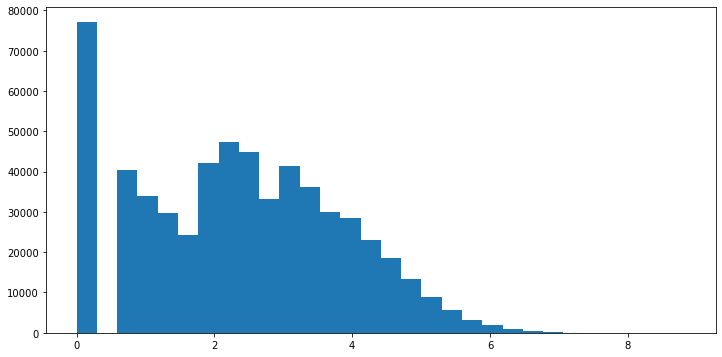

In [26]:
plt.figure(figsize=(12, 6))
plt.hist(np.log(log_length_list), bins=30)
plt.show()

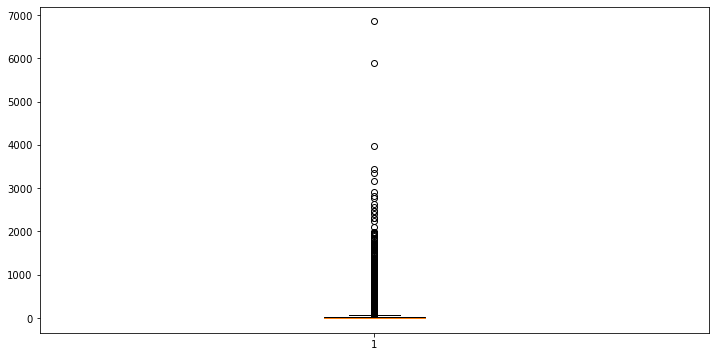

In [27]:
plt.figure(figsize=(12, 6))
plt.boxplot(log_length_list)
plt.show()

# 파생컬럼 - user별 각 log event의 횟수

In [18]:
event_set = list(set(log_data['event']))

In [19]:
event_num = []
for i in range(len(event_set)):
    print(event_set[i], len(log_data[log_data['event']==event_set[i]]))
    event_num.append(len(log_data[log_data['event']==event_set[i]]))

GetCreditInfo 2661997
Login 2463755
SignUp 34892
CompleteIDCertification 1237777
OpenApp 3460762
EndLoanApply 2715253
UseDSRCalc 4665
ViewLoanApplyIntro 1804712
StartLoanApply 1893914
UseLoanManage 1558906
UsePrepayCalc 7360


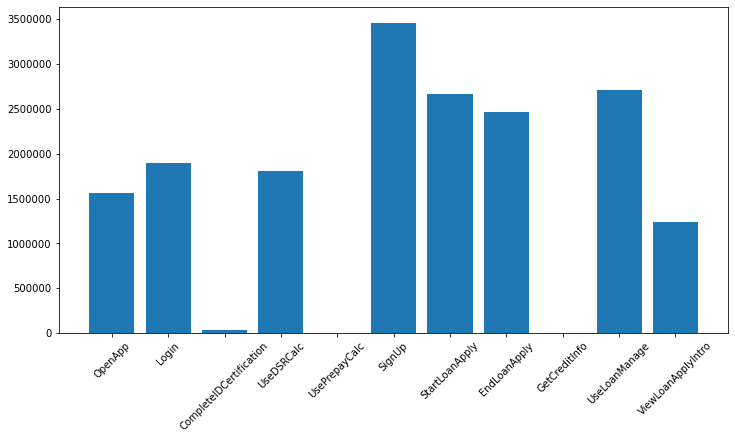

In [31]:
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(event_num)), event_num) 
plt.ticklabel_format(style='plain')
plt.xticks([0, 1, 2,3,4,5,6,7,8,9,10], ['OpenApp', 'Login', 'CompleteIDCertification','UseDSRCalc','UsePrepayCalc'
                                        ,'SignUp','StartLoanApply','EndLoanApply','GetCreditInfo','UseLoanManage','ViewLoanApplyIntro'],rotation=45)
plt.show()

In [20]:
c1 = data['user_id']

In [21]:
c1=c1.drop_duplicates()
c1 = c1.reset_index(drop=True)
c2 = np.zeros(len(c1))

In [40]:
log_df = pd.concat([pd.DataFrame(c1),pd.DataFrame(c2),pd.DataFrame(c2),pd.DataFrame(c2),pd.DataFrame(c2),pd.DataFrame(c2),pd.DataFrame(c2),pd.DataFrame(c2),pd.DataFrame(c2),pd.DataFrame(c2),pd.DataFrame(c2),pd.DataFrame(c2)], axis=1, ignore_index=True)
log_df.columns = ['user_id','OpenApp', 'Login', 'CompleteIDCertification','UseDSRCalc','UsePrepayCalc'
                                        ,'SignUp','StartLoanApply','EndLoanApply','GetCreditInfo','UseLoanManage','ViewLoanApplyIntro']

In [41]:
log_df
log_df.set_index('user_id',inplace=True)
log_df

,OpenApp,Login,CompleteIDCertification,UseDSRCalc,UsePrepayCalc,SignUp,StartLoanApply,EndLoanApply,GetCreditInfo,UseLoanManage,ViewLoanApplyIntro
user_id,,,,,,,,,,,
430982.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345273.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3058.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181137.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
564079.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77460.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
bab = log_df.index

In [43]:
for i in tqdm(bab):
    vvv = log_data[log_data['user_id']==i]
    log_df.loc[i,Counter(vvv.iloc[:,1]).keys()]=Counter(vvv.iloc[:,1]).values()

100%|████████████████████████████████████████████████████████████████████████| 317468/317468 [2:51:23<00:00, 30.87it/s]


In [46]:
log_df = log_df.reset_index()
log_df

,user_id,OpenApp,Login,CompleteIDCertification,UseDSRCalc,UsePrepayCalc,SignUp,StartLoanApply,EndLoanApply,GetCreditInfo,UseLoanManage,ViewLoanApplyIntro
0,430982.0,42.0,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0
1,345273.0,18.0,19.0,8.0,0.0,0.0,0.0,17.0,28.0,2.0,6.0,20.0
2,3058.0,2.0,3.0,3.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,4.0
3,181137.0,3.0,0.0,4.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,4.0
4,197454.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
317463,564079.0,15.0,12.0,4.0,0.0,0.0,0.0,2.0,4.0,16.0,9.0,11.0
317464,364214.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
317465,77460.0,38.0,32.0,5.0,0.0,0.0,0.0,7.0,12.0,18.0,8.0,7.0
317466,876482.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0


In [47]:
data = pd.merge(data, log_df, on = 'user_id', how = 'left')
data.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,Login,CompleteIDCertification,UseDSRCalc,UsePrepayCalc,SignUp,StartLoanApply,EndLoanApply,GetCreditInfo,UseLoanManage,ViewLoanApplyIntro
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0


In [48]:
data.to_csv('./data/rawdata_tmp.csv', index=False, encoding = 'utf-8')

# 파생컬럼 - application_id 별 금리순, 한도순 순위

In [52]:
rawdata_tmp = data

In [58]:
rawdata_tmp.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,Login,CompleteIDCertification,UseDSRCalc,UsePrepayCalc,SignUp,StartLoanApply,EndLoanApply,GetCreditInfo,UseLoanManage,ViewLoanApplyIntro
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,1996.0,1.0,...,0.0,15.0,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0


In [55]:
tmp = rawdata_tmp[['application_id','bank_id','product_id','loan_limit','loan_rate']]
tmp

,application_id,bank_id,product_id,loan_limit,loan_rate
0,1748340,7,191,42000000.0,13.6
1,1748340,25,169,24000000.0,17.9
2,1748340,2,7,24000000.0,18.5
3,1748340,4,268,29000000.0,10.8
4,1748340,11,118,5000000.0,16.4
...,...,...,...,...,...
13527358,1428218,62,200,3000000.0,14.8
13527359,1428218,2,7,40000000.0,11.8
13527360,1428218,32,257,15000000.0,7.2
13527361,1428218,33,110,44000000.0,13.5


In [56]:
app_list = list(dict.fromkeys(tmp['application_id']))
app_list

[1748340,
 830336,
 728546,
 1641986,
 937515,
 629707,
 691052,
 2083853,
 1410836,
 1399034,
 560448,
 2155640,
 953094,
 1311433,
 68170,
 1797950,
 632967,
 1747456,
 1065758,
 1117883,
 385410,
 2021320,
 107628,
 2019890,
 2112580,
 2045163,
 2146983,
 2088127,
 1882657,
 226887,
 175852,
 1029177,
 1545691,
 1798392,
 1138885,
 97844,
 282459,
 1901749,
 1386770,
 681506,
 2097522,
 101440,
 2157489,
 2006317,
 1351600,
 1976826,
 1870283,
 1677450,
 2052716,
 2155379,
 1397132,
 900266,
 763283,
 2143794,
 1991412,
 1211448,
 424084,
 857133,
 1172882,
 1615033,
 337366,
 1966421,
 854546,
 1846802,
 1162353,
 43981,
 1505370,
 1808664,
 295053,
 990662,
 1963697,
 310991,
 1487870,
 1918113,
 1242350,
 1466123,
 658266,
 1464334,
 1429944,
 1996916,
 377700,
 10554,
 722245,
 1530135,
 1129704,
 31316,
 552022,
 641366,
 89073,
 1553085,
 1462160,
 1743530,
 2020704,
 1240130,
 1568216,
 2089615,
 1571170,
 273609,
 2088759,
 162637,
 1975382,
 1079867,
 895125,
 1238489,
 105

In [57]:
rank_df = pd.DataFrame()

for i in tqdm(range(len(app_list))):
    ttmp = tmp[tmp['application_id']==app_list[i]][['loan_limit','loan_rate']]
    ttmp_rank = ttmp.rank(ascending=False)
    ttmp_df = pd.concat([ttmp,ttmp_rank],axis=1)
    ttmp_df.columns = ['loan_limit','loan_rate','loan_limit_rank','loan_rate_rank']
    rank_df = pd.concat([rank_df,ttmp_df],axis=0)

100%|███████████████████████████████████████████████████████████████████████| 968866/968866 [27:49:39<00:00,  9.67it/s]


In [59]:
rank_df.head()

,loan_limit,loan_rate,loan_limit_rank,loan_rate_rank
0,42000000.0,13.6,3.0,22.5
1,24000000.0,17.9,16.0,5.0
2,24000000.0,18.5,16.0,2.0
3,29000000.0,10.8,10.0,33.0
4,5000000.0,16.4,31.5,8.5


In [62]:
rank_df2 = rank_df.drop(['loan_limit','loan_rate'],axis=1, inplace=False)
rank_df2

,loan_limit_rank,loan_rate_rank
0,3.0,22.5
1,16.0,5.0
2,16.0,2.0
3,10.0,33.0
4,31.5,8.5
...,...,...
13527358,37.0,11.0
13527359,10.5,23.0
13527360,24.5,35.0
13527361,5.0,16.0


In [63]:
data = pd.merge(rawdata_tmp, rank_df2, left_index=True, right_index=True, how='left')
data.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,UseDSRCalc,UsePrepayCalc,SignUp,StartLoanApply,EndLoanApply,GetCreditInfo,UseLoanManage,ViewLoanApplyIntro,loan_limit_rank,loan_rate_rank
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,1996.0,1.0,...,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0,3.0,22.5
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,1996.0,1.0,...,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0,16.0,5.0
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,1996.0,1.0,...,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0,16.0,2.0
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,1996.0,1.0,...,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0,10.0,33.0
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,1996.0,1.0,...,0.0,0.0,0.0,50.0,50.0,2.0,1.0,16.0,31.5,8.5


In [65]:
data.isnull().sum()

application_id                                0
loanapply_insert_time                         0
bank_id                                       0
product_id                                    0
loan_limit                                 7495
loan_rate                                  7495
is_applied                              3257239
user_id                                     113
birth_year                               128209
gender                                   128209
insert_time                                 113
credit_score                            1509389
yearly_income                               119
income_type                                 113
company_enter_month                      400450
employment_type                             113
houseown_type                               113
desired_amount                              113
purpose                                     113
personal_rehabilitation_yn              5888814
personal_rehabilitation_complete_yn    1

# 결측치 처리

In [34]:
df = data

In [29]:
df.drop(columns=['personal_rehabilitation_yn',
       'personal_rehabilitation_complete_yn'],axis=1, inplace =True)

In [30]:
df1 = df[df['is_applied'].isnull()==False]

In [31]:
df1.dropna(inplace=True)

C:\Users\sjkan\AppData\Local\Temp\ipykernel_6552\3614008390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(inplace=True)


In [14]:
len(df1)

6710290

In [67]:
df1

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,UseDSRCalc,UsePrepayCalc,SignUp,StartLoanApply,EndLoanApply,GetCreditInfo,UseLoanManage,ViewLoanApplyIntro,loan_limit_rank,loan_rate_rank
13284,2157865,2022-05-09 08:44:59,54,235,20000000.0,16.5,1.0,346970.0,1970.0,1.0,...,0.0,0.0,0.0,4.0,13.0,6.0,5.0,5.0,1.0,1.0
13285,576643,2022-05-09 10:54:53,54,235,11000000.0,16.5,0.0,545882.0,1977.0,1.0,...,0.0,0.0,0.0,19.0,21.0,0.0,0.0,14.0,1.0,2.0
13286,576643,2022-05-09 10:54:53,11,118,3000000.0,20.0,0.0,545882.0,1977.0,1.0,...,0.0,0.0,0.0,19.0,21.0,0.0,0.0,14.0,2.0,1.0
13287,2136706,2022-05-09 10:41:06,42,216,10000000.0,13.5,0.0,558819.0,1983.0,1.0,...,0.0,0.0,0.0,32.0,29.0,18.0,15.0,7.0,32.0,21.0
13288,2136706,2022-05-09 10:41:07,25,169,22000000.0,15.9,0.0,558819.0,1983.0,1.0,...,0.0,0.0,0.0,32.0,29.0,18.0,15.0,7.0,20.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13519634,1969227,2022-05-16 14:42:58,2,7,30000000.0,13.6,0.0,109899.0,1977.0,1.0,...,0.0,0.0,0.0,23.0,33.0,11.0,6.0,28.0,1.0,10.0
13519635,1969227,2022-05-16 14:42:57,33,110,9000000.0,14.4,0.0,109899.0,1977.0,1.0,...,0.0,0.0,0.0,23.0,33.0,11.0,6.0,28.0,4.0,9.0
13519636,1969227,2022-05-16 14:42:56,50,142,3000000.0,11.2,0.0,109899.0,1977.0,1.0,...,0.0,0.0,0.0,23.0,33.0,11.0,6.0,28.0,11.5,13.0
13519637,1969227,2022-05-16 14:43:18,22,100,4000000.0,15.3,0.0,109899.0,1977.0,1.0,...,0.0,0.0,0.0,23.0,33.0,11.0,6.0,28.0,8.0,5.0


In [69]:
loan = df1

loan = loan[['bank_id','is_applied']]
loan.dropna(inplace=True)
a = loan.groupby('bank_id').count()
b = loan.groupby('bank_id').sum()
c = b/a
c = c.rename(columns={'is_applied':'bank_ratio'})
d = pd.merge(loan,c, on = 'bank_id', how = 'left')

C:\Users\sjkan\AppData\Local\Temp\ipykernel_6552\2531176081.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan.dropna(inplace=True)


In [72]:
df_INNER_JOIN = pd.merge(df1, d, left_on='bank_id', right_on='bank_id', how='inner')

In [73]:
df_INNER_JOIN.to_csv('./data/tmp777.csv', index=False, encoding = 'utf-8')